**Installing NLTK package**

In [1]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Downloading Brown Corpus**

In [2]:
import nltk
import numpy as np
from nltk.corpus import brown
from sklearn.model_selection import train_test_split
nltk.download('brown')
nltk.download('universal_tagset')
nltk.download('punkt')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Extracting words from sentences**

In [3]:
def sents_to_words(sents_data):
  words_data = []
  for sent_index in range(len(sents_data)):
    for word_index in range(len(sents_data[sent_index])): 
      words_data.append(sents_data[sent_index][word_index])
  return words_data

**Making a dictionary for words**

In [4]:
def words_dict(sents_data):
  words_data = sents_to_words(sents_data)
  words = list(set([i[0].lower() for i in words_data]))
  words_index = dict(zip(words, range(len(words))))
  return words_index

**Calculating transition probabilities**

In [5]:
def transitions(train_data):
  tagged_sequences = []
  for i in range(len(train_data)):
    tagged_sequences.append([tag_index[word[1]] for word in train_data[i]])
  transition_table = np.zeros((len(tags),len(tags)))
  for s in range(len(tagged_sequences)):
    for (i,j) in zip(tagged_sequences[s],tagged_sequences[s][1:]):
      transition_table[i][j] += 1
  count_matrix = []
  for row in transition_table:
      n = sum(row)
      count_matrix.append(n)
      if n > 0:
          row[:] = [(val+1)/(n+len(tags)) for val in row]
  transition_table[len(transition_table)-1][0] = 1
  return transition_table,count_matrix

**Calculating lexical probabilities**

In [6]:
def emmissions(train_data, words_index):
  words_data = sents_to_words(train_data)
  emmission_table = np.zeros((len(tags),len(words_data)))
  emmission_table = emmission_table.astype('float64')
  for word in words_data:
    emmission_table[tag_index[word[1]]][words_index[word[0].lower()]]+=1
  for row in emmission_table:
      n = sum(row)
      if n > 0:
          row[:] = [val/n for val in row]
  return emmission_table

**Viterbi Algorithm**

In [7]:
def viterbi(word_list, transition_table, emmission_table, words_index, count_matrix):
  for i in range(len(word_list)):
    word_list[i] = word_list[i].lower()
  A = np.copy(transition_table)
  A = A[0][1:-1]
  B = np.empty([len(tags)-2, len(tags)-2])
  prev_path = [[]]*(len(tags)-2)
  next_path = [[]]*(len(tags)-2)
  for word in word_list[:-1]:
    for i in range(len(tags)-2):
      for j in range(len(tags)-2):
        if word in words_index.keys():
          B[i][j] = A[i]*transition_table[i+1][j+1]*emmission_table[i+1][words_index[word]]
        else:
          B[i][j] = A[i]*transition_table[i+1][j+1]*(1/(count_matrix[i+1]+len(words_index)))
    A = np.amax(B, axis=0)
    index = np.argmax(B, axis=0)
    for i in range(len(tags)-2):
      next_path[i] = prev_path[index[i]] + [index[i]+1]
    prev_path = next_path[:]
  for i in range(len(tags)-2):
    if word_list[-1] in words_index.keys():
      A[i] = A[i]*transition_table[i+1][len(tags)-1]*emmission_table[i+1][words_index[word_list[-1]]]
    else:
      A[i] = A[i]*transition_table[i+1][len(tags)-1]*(1/(count_matrix[i+1]+len(words_index)))
  last_index = np.argmax(A, axis=0)
  final_path = prev_path[last_index] + [last_index+1]
  for i in range(len(final_path)):
    final_path[i] = index_to_tag[final_path[i]]
  return final_path

**Defining the tagset**

In [8]:
corpus_words = nltk.corpus.brown.tagged_words(tagset='universal')
tags = list(set([i[1] for i in corpus_words])) # Unique tags
tags.sort()
tags = ['^'] + tags + ['END']
tag_index = dict(zip(tags, range(len(tags))))
index_to_tag = dict(zip(range(len(tags)),tags))

**UNIVERSAL TAGSET**

^ : Start (0)

. : Punctuation (1)

ADJ : adjective (2)

ADP : adposition (3)
 
ADV : adverb (4)

CONJ : conjunction (5)

DET : determiner (6)

NOUN : noun (7)

NUM : numeral (8)

PRT : particle (9)

PRON : pronoun (10)

VERB : verb (11)

X : other (12)

END : End (13)

**Extracting sentences from Brown Corpus**

In [9]:
corpus_sents = np.asarray(nltk.corpus.brown.tagged_sents(tagset='universal'))
discard = []
for i in range(len(corpus_sents)):
  if(len(corpus_sents[i])==1 and corpus_sents[i][0][1]=='.'):
    discard.append(i)
corpus_sents = np.delete(corpus_sents, discard)
corpus_sents = corpus_sents.tolist()
for i in range(len(corpus_sents)):
  corpus_sents[i].insert(0,('^','^'))
  if corpus_sents[i][-1][1] != '.':
    corpus_sents[i].append(('.','END'))
  else:
    end = corpus_sents[i][-1][0]
    corpus_sents[i] = corpus_sents[i][:-1] 
    corpus_sents[i].append((end,'END'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


**Performing K-Fold Cross Validation on the model**

In [10]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, random_state=None, shuffle=True)
corpus_sents = np.asarray(corpus_sents)
confusion_matrix = np.zeros((len(tags)-2,len(tags)-2))
confusion_matrix = confusion_matrix.astype('float64')
accuracy = []
for train, test in kfold.split(corpus_sents):
  training_data = corpus_sents[train]
  training_data = training_data.tolist()
  test_data = corpus_sents[test]
  test_data = test_data.tolist()
  words_index = words_dict(training_data)
  transition_table,count_matrix = transitions(training_data)
  emmission_table = emmissions(training_data,words_index)
  correct_tags = 0
  total_tags = 0
  for sent in test_data:
    words_list = []
    tags_list = []
    for i in range(len(sent)):
      words_list.append(sent[i][0])
      tags_list.append(sent[i][1])
    tags_list = tags_list[1:-1]
    POS_tag = viterbi(words_list[1:-1], transition_table, emmission_table, words_index, count_matrix)
    total_tags += len(POS_tag)
    for i in range(len(POS_tag)):
      confusion_matrix[tag_index[tags_list[i]]-1][tag_index[POS_tag[i]]-1] += 1
      if POS_tag[i]==tags_list[i]:
        correct_tags += 1
  accuracy.append(correct_tags/total_tags)
final_accuracy = np.mean(accuracy)
print(final_accuracy*100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


95.64034349640303


**Calculating Precision, Recall and F-scores**

In [11]:
def Fscore(beta,precision,recall):
  return (1+beta*beta)*precision*recall/(beta*beta*precision + recall)

In [12]:
precision = []
recall = []
for i in range(len(confusion_matrix)):
  precision.append(confusion_matrix[i][i]/sum(confusion_matrix[:,i]))
  recall.append(confusion_matrix[i][i]/sum(confusion_matrix[i]))
F1_score = []
F2_score = []
Fhalf_score = []
for i in range(len(recall)):
  F1_score.append(Fscore(1,precision[i],recall[i]))
  F2_score.append(Fscore(2,precision[i],recall[i]))
  Fhalf_score.append(Fscore(0.5,precision[i],recall[i]))

**Plotting the heat map for confusion matrix**

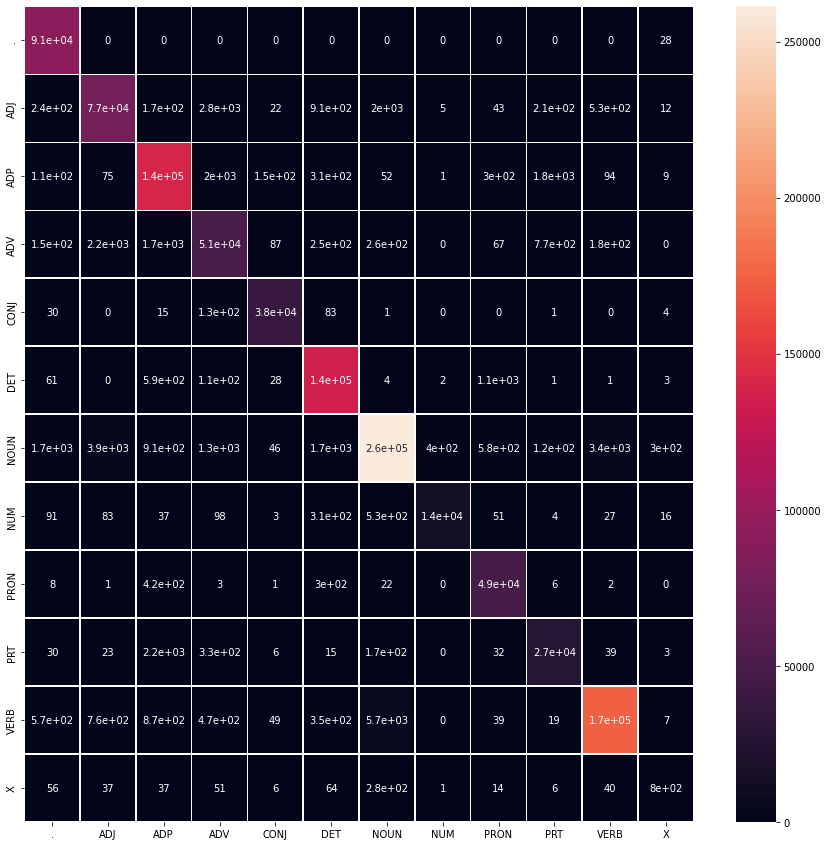

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

c = np.empty((len(confusion_matrix),len(confusion_matrix)))
for i in range(len(confusion_matrix)):
  for j in range(len(confusion_matrix)):
    c[i][j] = round(confusion_matrix[i][j],2)
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(c, annot=True, linewidths=.5, ax=ax, xticklabels=tags[1:-1], yticklabels=tags[1:-1])

**Performing POS tagging on user input sentence**

In [14]:
words_index = words_dict(corpus_sents)
transition_table,count_matrix = transitions(corpus_sents)
emmission_table = emmissions(corpus_sents,words_index)

In [15]:
input_sentence = input() # Enter the sentence

I walked in the park


In [ ]:
nltk.download('punkt')
lst = nltk.word_tokenize(input_sentence)
POS_tag = viterbi(lst, transition_table, emmission_table, words_index, count_matrix)
print(POS_tag)